LSTM
==

In [1]:
import os
from random import shuffle

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
filename= '../data/nlexique.csv'
df = pd.read_csv(filename)
df = df[['lexeme', 'sg', 'gen']].rename(columns={'lexeme': 'orthography', 'sg': 'phonetic trasncription', 'gen': 'gender'})
df.head(10)

,orthography,phonetic trasncription,gender
0,à-côté,akOte,m
1,à-coup,aku,m
2,à-peu-près,apØpʁɛ,m
3,à-pic,apik,m
4,à-plat,apla,m
5,à-propos,apʁOpo,m
6,à-valoir,avalwaʁ,m
7,a,a,m
8,aa,aa,m
9,abaca,abaka,m


In [4]:
# Datasets with the 'b class
orthography_data_3gen = df[['orthography', 'gender']].dropna()
phonetic_data_3gen = df[['phonetic trasncription', 'gender']].dropna()

In [5]:
# Datasets without the 'b' class
orthography_data_2gen = df[df['gender'] != 'b'][['orthography', 'gender']].dropna()
phonetic_data_2gen = df[df['gender'] != 'b'][['phonetic trasncription', 'gender']].dropna()

In [6]:
def reverse_sequence(noun):
    return noun[::-1]

def pad_sequence(sequence,pad_size,pad_token):
    # returns a list of the characters in the sequence with additional pad tokens to match pad_size if needed
    return list(sequence) + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap,unk_token='<unk>'):
    # charseq is a sequence of chars
    return [encodingmap[char] if char in encodingmap 
            else encodingmap[unk_token] for char in charseq]

def decode_sequence(idxseq,decodingmap):
    # idxseq is a list of integers
    return [decodingmap[idx] for idx in idxseq]

In [7]:
def read_data(filename, reverse_nouns=False):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [line.strip() for line in file.readlines()]

    X, y = [], []
    for pair in data:
        noun, gender = pair.split(', ')
        if reverse_nouns:
            noun = reverse_sequence(noun)
        noun_chars = [char for char in noun] # split the nouns into characters
        X.append(noun_chars)
        y.append(gender)
    
    return X, y

In [8]:
# To be used with data frames
def get_data(df, reverse_nouns=False):
    nouns = df.iloc[:,0].tolist()
    gender = df.iloc[:,1].tolist()   
    if reverse_nouns:
        nouns = [reverse_sequence(noun) for noun in nouns]
    noun_chars = [[char for char in noun] for noun in nouns]
    return noun_chars, gender

In [12]:
def vocabulary(data, labels=False, pad_token='<pad>', unk_token='<unk>', df=False):
    
    if df:
        nouns, genders = get_data(data, reverse_nouns=False)
    else:
        nouns, genders = read_data(data, reverse_nouns=False)
    
    if labels:
        sym2idx = {sym: idx for idx, sym in enumerate(set(genders))}
    else:
        unique_chars = set(char for noun in nouns for char in noun)
        sym2idx = {sym: idx for idx, sym in enumerate(unique_chars)}
        sym2idx[unk_token] = len(sym2idx)
        sym2idx[pad_token] = len(sym2idx)

    idx2sym = [sym for sym in sym2idx.keys()]

    return idx2sym, sym2idx

In [10]:
def save_padded_words(filename, batch_of_words):
    lines = ['\t'.join(word) + '\n' for word in batch_of_words]
    with open(filename, 'a', encoding='utf-8') as f:
        f.writelines(lines)

In [26]:
# Inspiration from code by Benoit Crabbé
class DataGenerator:

      def __init__(self, data, reverse_nouns=False, pad_token='<pad>', unk_token='<unk>', df=False):

            self.pad_token = pad_token
            self.unk_token = unk_token

            self.input_idx2sym,self.input_sym2idx   = vocabulary(data,False,df=df)
            self.output_idx2sym,self.output_sym2idx = vocabulary(data,True,df=df)

            if df:
                nouns, genders = get_data(data, reverse_nouns=reverse_nouns)
            else:
                nouns, genders = read_data(data, reverse_nouns=reverse_nouns)
            
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(nouns, genders, test_size=0.2)

            self.train_size = len(self.X_train)
            self.test_size = len(self.X_test)

      def generate_batches(self,batch_size,validation=False):

            if validation:
                X = self.X_test
                y = self.y_test
            else:
                X = self.X_train
                y = self.y_train

            assert(len(X) == len(y))

            N     = len(X)
            idxes = list(range(N))

            # Data ordering
            shuffle(idxes)
            idxes.sort(key=lambda idx: len(X[idx]))

            # batch generation
            bstart = 0
            while bstart < N:
                bend        = min(bstart+batch_size,N)
                batch_idxes = idxes[bstart:bend]
                batch_len   = max(len(X[idx]) for idx in batch_idxes)
                Xpad        = [pad_sequence(X[idx],batch_len,self.pad_token) for idx in batch_idxes]
                #   save_padded_words('../data/eval/padded_fr', Xpad)
                seqX        = [code_sequence(x,self.input_sym2idx,self.unk_token) for x in Xpad]
                seqY        = [self.output_sym2idx[y[idx]] for idx in batch_idxes]

                assert(len(seqX) == len(seqY))
                yield (seqX,seqY)
                bstart += batch_size

Model
==

Train the model by feeding it words in reverse order (since we want to start from the end of the word) and the corresponding genders. The model will learn to predict the gender based on the characters seen so far.

Takes preprocessed words as input:
- tokenized into characters 
- each character mapped to a unique integer id (same with each gender)
- sequences should be padded so they all have the same length

In [102]:
# Third version:
class GenderLSTM(nn.Module):

    def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
        super(GenderLSTM, self).__init__()
        self.to(device)

        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)

        self.device = torch.device(device)
        self.pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
        self.embedding = nn.Embedding(invocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, outvocab_size)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, inputs):
        embeds = self.embedding(inputs)
        
        # lstm_out contains the hidden states for each time step in the input sequence for each element in the batch. Shape: [batch_size, sequence_length, hidden_size]
        # hidden is the hidden state for the last time step in the input sequence for each element in the batch. Shape: [num_layers(* num_directions which is 1 here), batch_size, hidden_size]
        lstm_out, (hidden, _) = self.lstm(embeds)   
        
        out_logits = self.fc(lstm_out)   # shape: [batch_size, sequence_length, num_classes] --> these will be used to get accuracy values for each time step
        
        #  taking the last hidden state of the last layer with hidden[-1]
        hidden_logits = self.fc(hidden[-1]) # shape: [batch_size, num_classes]  --> these will be used for loss computation

        # add softmax to get probability distributions (for easier interpretability)
        out_probabilities = self.softmax(out_logits)   # probability distribution over the classes for each character in the sequence 
        # it would also be a good idea to calibrate the model (dividing c by a value T (tempreture) that is a hyperparameter that can be tuned --> ask Timothee)
        return out_probabilities, hidden_logits  


    def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001, verbose=True, save_model=True, model_path='../saved_models/GenderLSTM_model.pth'):
        criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        train = {'accuracy': [],
                 'loss': [],
                 'plateau_beg': [], 
                 'acc_at_plateau_beg': []
                 }
            
        valid = {'accuracy': [],
                 'loss': [],
                 'plateau_beg': [], 
                 'acc_at_plateau_beg': []
                 }

        max_val_acc = 0
        patience = 3
        counter = 0
        
        for epoch in range(n_epochs):
            
            if verbose:
                print(f'Epoch: {epoch}')
            
            epoch_train_accuracies = [] 
            epoch_valid_accuracies = []
            epoch_train_losses = []
            epoch_valid_losses = []
            train_plateau_indecies = [] # will contain the index of the position at which the accuracy starts to plateau for each batch
            valid_plateau_indecies = []
            train_plateau_accuracies = []   # will contain the accuracy of the position at which the accuracy starts to plateau for each batch
            valid_plateau_accuracies = []

            train_char_predictions = {} # will contain the tokens in the training set as keys and lists of 0s or 1s indicating incorrect or correct prediction at each character position in the tokens as values
            valid_char_predictions = {} # will contain the tokens in the validation set as keys and lists of 0s or 1s indicating incorrect or correct prediction at each character position in the tokens as values
            
            # Training phase
            self.train()
            for inputs, labels in datagenerator.generate_batches(batch_size):
                X = torch.LongTensor(inputs).to(self.device) # shape: [batch_size, sequence_length]
                Y = torch.LongTensor(labels).to(self.device) # shape: [batch_size]

                optimizer.zero_grad()
                Y_seq_probs, Y_hidden_logits = self.forward(X)    # shapes: [batch_size, sequence_length, num_classes], [batch_size, num_classes]

                # Loss
                loss = criterion(Y_hidden_logits, Y)
                loss.backward()
                optimizer.step()
                epoch_train_losses.append(loss.item())

                # Accuracy
                Y_pred = torch.argmax(Y_hidden_logits, dim=-1)  # shape: [batch_size]
                correct = (Y_pred == Y)
                avg_batch_accuracy = correct.float().mean()  # scalar
                epoch_train_accuracies.append(avg_batch_accuracy)

                # Character-level predictions
                pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
                Y_pred_seq = torch.argmax(Y_seq_probs, dim=-1)  # shape: [batch_size, sequence_length]
                correct = (Y_pred_seq == Y.unsqueeze(1))
                # mask = (Y_pred_seq != pad_idx)              
                for i in range(len(X)):
                    word = ''.join([datagenerator.input_idx2sym[idx] for idx in X[i] if idx != pad_idx])
                    train_char_predictions[word] = [float(correct[i, idx].item()) for idx in range(len(correct[i])) if idx != pad_idx]

                # Plateau info
                plateau_position, plateau_accuracy = self.get_plateau_info(Y_seq_probs, Y, threshold=0.01, patience=3) 
                train_plateau_indecies.append(plateau_position)
                train_plateau_accuracies.append(plateau_accuracy)

            # Validation phase
            self.eval()
            for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
                with torch.no_grad():
                    X = torch.LongTensor(val_inputs).to(self.device)
                    Y = torch.LongTensor(val_labels).to(self.device)

                    Y_seq_probs, Y_hidden_logits = self.forward(X)

                    # Loss
                    loss = criterion(Y_hidden_logits, Y)
                    epoch_valid_losses.append(loss.item())

                    # Accuracy
                    Y_pred = torch.argmax(Y_hidden_logits, dim=-1)  # shape: [batch_size]
                    correct = (Y_pred == Y)
                    avg_batch_accuracy = correct.float().mean()  # scalar
                    epoch_valid_accuracies.append(avg_batch_accuracy)

                    # Character-level predictions
                    Y_pred_seq = torch.argmax(Y_seq_probs, dim=-1)  # shape: [batch_size, sequence_length]
                    correct = (Y_pred_seq == Y.unsqueeze(1))
                    # mask = (Y_pred_seq != pad_idx)              
                    for i in range(len(X)):
                        word = ''.join([datagenerator.input_idx2sym[idx] for idx in X[i] if idx != pad_idx])
                        valid_char_predictions[word] = [float(correct[i, idx].item()) for idx in range(len(correct[i])) if idx != pad_idx]

                    # Plateau info
                    plateau_position, plateau_accuracy = self.get_plateau_info(Y_seq_probs, Y, threshold=0.01, patience=3) 
                    valid_plateau_indecies.append(plateau_position)
                    valid_plateau_accuracies.append(plateau_accuracy) 


            # store (and, if verbose is True, report) metrics at the end of each epoch
            avg_train_accuracy = sum(epoch_train_accuracies) / len(epoch_train_accuracies)
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)  
            train_plateau_beg = max(set(train_plateau_indecies), key=train_plateau_indecies.count)  # should I get the one that appears the most or the average?
            train_acc_at_plateau_beg = train_plateau_accuracies[train_plateau_beg]                    
            
            avg_valid_accuracy = sum(epoch_valid_accuracies) / len(epoch_valid_accuracies)
            avg_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
            valid_plateau_beg = max(set(valid_plateau_indecies), key=valid_plateau_indecies.count)
            valid_acc_at_plateau_beg = valid_plateau_accuracies[valid_plateau_beg]

            train['accuracy'].append(avg_train_accuracy)
            train['loss'].append(avg_train_loss)
            train['plateau_beg'].append(train_plateau_beg)
            train['acc_at_plateau_beg'].append(train_acc_at_plateau_beg)
            
            valid['accuracy'].append(avg_valid_accuracy)
            valid['loss'].append(avg_valid_loss)
            valid['plateau_beg'].append(valid_plateau_beg)
            valid['acc_at_plateau_beg'].append(valid_acc_at_plateau_beg)

            if verbose:
                print(f'[Train] Loss: {avg_train_loss:.4f}   Accuracy: {avg_train_accuracy * 100:.2f}%   Beginning of plateau (index): {train_plateau_beg}   Accuracy at the beginning of plateau: {train_acc_at_plateau_beg * 100:.2f}%')      
                print(f'[Valid] Loss: {avg_valid_loss:.4f}   Accuracy: {avg_valid_accuracy * 100:.2f}%   Beginning of plateau (index): {valid_plateau_beg}   Accuracy at the beginning of plateau: {valid_acc_at_plateau_beg * 100:.2f}%')
                print('-' * 100)

            # checking for early stopping
            if avg_valid_accuracy > max_val_acc:
                max_val_acc = avg_valid_accuracy
                counter = 0
                if save_model:
                    # save model checkpoint
                    checkpoint = {
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch,
                        'train_accuracy': avg_train_accuracy,
                        'train_loss': avg_train_loss,
                        'train_plateau_beg': train_plateau_beg,
                        'train_acc_at_plateau_beg': train_acc_at_plateau_beg,
                        'train_char_predictions': train_char_predictions,
                        'valid_accuracy': avg_valid_accuracy,
                        'valid_loss': avg_valid_loss,
                        'valid_plateau_beg': valid_plateau_beg,
                        'valid_acc_at_plateau_beg': valid_acc_at_plateau_beg,
                        'valid_char_predictions': valid_char_predictions,
                    }
                    torch.save(checkpoint, model_path)
            else:
                counter += 1

            if counter == patience:
                if verbose:
                    print(f'Early stopping after {epoch + 1} epochs and {patience} epochs without improvement.')
                break

        return train, valid


    def predict(self, datagenerator, batch_size):
        predictions = {'Word': [], 'Predicted Gender': [], 'True Gender': []}
        
        self.eval()
        for inputs, labels in datagenerator.generate_batches(batch_size, validation=True):
            with torch.no_grad():
                X = torch.LongTensor(inputs).to(self.device)
                Y = torch.LongTensor(labels).to(self.device)

                _, logits = self.forward(X)
                Y_pred = torch.argmax(logits, dim=-1)

                # converting the predictions into readable format
                pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
                for i in range(len(X)):
                    predictions['Word'].append(''.join([datagenerator.input_idx2sym[idx] for idx in X[i] if idx != pad_idx]))
                    predictions['Predicted Gender'].append(datagenerator.output_idx2sym[Y_pred[i]])
                    predictions['True Gender'].append(datagenerator.output_idx2sym[Y[i]])
        
        return predictions


    def get_plateau_info(self, Y_probs, Y, threshold=0.01, patience=3):
        Y_pred = torch.argmax(Y_probs, dim=-1)  # shape: [batch_size, sequence_length]
        correct = (Y_pred == Y.unsqueeze(-1))
        avg_pos_accuracy = correct.float().mean(dim=0)

        # if the accuracy doesn't increase by a value higher than the threshold for patience consecutive characters, extract the index and accuracy of the initial position
        # print(avg_pos_accuracy)
        counter = 0
        for position, accuracy in enumerate(avg_pos_accuracy):
            if position == 0: 
                continue
            elif accuracy - avg_pos_accuracy[position - 1] >= threshold:
                counter = 0
            elif accuracy - avg_pos_accuracy[position - 1] < threshold:
                counter += 1

            if counter == patience:
                plateau_position = position - patience
                plateau_accuracy = avg_pos_accuracy[position - patience]
                return plateau_position, plateau_accuracy

        # if there is no plateau, returns the position and accuracy of the last character
        return len(avg_pos_accuracy)-1, avg_pos_accuracy[-1]
    

In [103]:
def plot_prediction_curve(word, predictions):
    print(f'predictions: {predictions}')
    plt.plot(range(len(predictions)), predictions)
    plt.title(f'Character Position Predictions in "{word}"')
    plt.xlabel('Character indecies')
    plt.ylabel('Correct (1) or Incorrect (0) Prediction')
    plt.show()


def view_plateau(word, model_checkpoint):
    """
    Checks to see if the word exists in the dataset and if so, plots the accuracy at each character position
    """
    checkpoint = torch.load(model_checkpoint)
    train_char_predictions = checkpoint['train_char_predictions']
    valid_char_predictions = checkpoint['valid_char_predictions']

    if word in train_char_predictions:
        print(f'{word} found in the training set.')
        plot_prediction_curve(word, train_char_predictions[word])
    elif word in valid_char_predictions:
        print(f'{word} found in the validation set')
        plot_prediction_curve(word, valid_char_predictions[word])
    else:
        print(f'{word} not found.')
        

In [15]:
def baseline_accuracy(datagenerator, verbose=False):
    _, train_labels = list(*datagenerator.generate_batches(datagenerator.train_size, validation=False))
    most_frequent_label = max(set(train_labels), key=train_labels.count)   
    
    if verbose:
        print(f'The most frequent label in the dataset is: {datagenerator.output_idx2sym[most_frequent_label]}')

    dev_labels = list(*datagenerator.generate_batches(datagenerator.test_size, validation=True))[1]
    return dev_labels.count(most_frequent_label) / len(dev_labels)

In [16]:
# def plot(train_acc, valid_acc, train_losses, valid_losses, train_max_indices, dev_max_indices):
def plot_metrics(train_acc, valid_acc, train_losses, valid_losses):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.subplots_adjust(hspace=0.5)

    n_epochs = range(1, len(valid_losses) + 1)

    # Plot accuracy
    ax1.set_title('Accuracy Evolution Over Epochs')
    ax1.plot(n_epochs, train_acc, marker='o', color='steelblue', label='Training Accuracy')
    ax1.plot(n_epochs, valid_acc, marker='o', color='orange', label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, linestyle='--')

    # Plot loss
    ax2.set_title('Loss Evolution Over Epochs')
    ax2.plot(n_epochs, train_losses, marker='o', color='steelblue', label='Training Loss')
    ax2.plot(n_epochs, valid_losses, marker='o', color='orange', label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    plt.show()

In [17]:
def compare_accuracies(baseline_acc, model_acc):
    
    x_labels = ['Baseline', 'Model']
    bar_colors = ['#FFDFD3', '#593e67'] # '#957DAD'
    bars = plt.bar(x_labels, [baseline_acc, model_acc], width=0.3, color=bar_colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title('Comparison Between Model Accuracy and Baseline Accuracy (= Most Frequent Class)')
    plt.ylabel('Accuracy')
    plt.grid(linestyle='dashed')
    ax = plt.gca()
    ax.set_axisbelow(True)

    plt.show()

In [55]:
def statistical_check(dataset, hyperparameters, runs=10, reverse_nouns=True, df=False, device='cpu'):
    """
    Returns the accuracy, loss, plateau beginning index, and accuracy at plateau beginning index 
            averaged over a specified number of runs for both training and validation sets.
    """
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    train_idx_plateau_beg, train_acc_plateau_beg, valid_idx_plateau_beg, valid_acc_plateau_beg = [], [], [], []
    
    embedding_dim = hyperparameters['embed_dim']
    hidden_size = hyperparameters['hidden_size']
    batch_size = hyperparameters['batch_size']
    n_epochs = hyperparameters['n_epochs']
    lr = hyperparameters['lr']

    for _ in range(runs):
        data_generator = DataGenerator(dataset, reverse_nouns=reverse_nouns, df=df)
        model = GenderLSTM(data_generator, embedding_dim, hidden_size, device=device)
        train, val = model.train_model(data_generator, n_epochs, batch_size, lr, verbose=False, save_model=False)
        
        train_loss.append(train['loss'][-1])
        train_acc.append(train['accuracy'][-1])
        valid_loss.append(val['loss'][-1])
        valid_acc.append(val['accuracy'][-1])

        train_idx_plateau_beg.append(train['plateau_beg'][-1])
        train_acc_plateau_beg.append(train['acc_at_plateau_beg'][-1])
        valid_idx_plateau_beg.append(val['plateau_beg'][-1])
        valid_acc_plateau_beg.append(val['acc_at_plateau_beg'][-1])


    t = {'avg_accuracy': sum(train_acc) / len(train_acc),
         'avg_loss': sum(train_loss) / len(train_loss),
         'avg_plateau_beg': int(sum(train_idx_plateau_beg) / len(train_idx_plateau_beg)), 
         'avg_acc_at_plateau_beg': sum(train_acc_plateau_beg) / len(train_acc_plateau_beg)
        }
            
    v = {'avg_accuracy': sum(valid_acc) / len(valid_acc),
         'avg_loss': sum(valid_loss) / len(valid_loss),
         'avg_plateau_beg': int(sum(valid_idx_plateau_beg) / len(valid_idx_plateau_beg)), 
         'avg_acc_at_plateau_beg': sum(valid_acc_plateau_beg) / len(valid_acc_plateau_beg)
        }

    print(f"Avg Train Loss: {t['avg_loss']:.4f}   Avg Train Accuracy: {t['avg_accuracy'] * 100:.2f}%   Avg Plateau Beginning (index): {t['avg_plateau_beg']}   Avg Plateau Beginning Accuracy: {t['avg_acc_at_plateau_beg'] * 100:.2f}%")      
    print(f"Avg Valid Loss: {v['avg_loss']:.4f}   Avg Valid Accuracy: {v['avg_accuracy'] * 100:.2f}%   Avg Plateau Beginning (index): {v['avg_plateau_beg']}   Avg Plateau Beginning Accuracy: {v['avg_acc_at_plateau_beg'] * 100:.2f}%")

    return t, v

### Orthographic Form (3 classes)

In [104]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
batch_size = 64
n_epochs = 20
lr = 0.001

or3_data_generator = DataGenerator(orthography_data_3gen, reverse_nouns=True, df=True)
or3_model = GenderLSTM(or3_data_generator, embedding_dim, hidden_size, device=DEVICE)
or3_train, or3_valid = or3_model.train_model(or3_data_generator, n_epochs, batch_size, lr, model_path='../saved_models/orthography_3gen.pth')

Epoch: 0
[Train] Loss: 0.4577   Accuracy: 83.76%   Beginning of plateau (index): 2   Accuracy at the beginning of plateau: 81.25%
[Valid] Loss: 0.4374   Accuracy: 85.81%   Beginning of plateau (index): 1   Accuracy at the beginning of plateau: 78.12%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3467   Accuracy: 87.43%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 82.81%
[Valid] Loss: 0.3517   Accuracy: 87.37%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 85.94%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3180   Accuracy: 88.55%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 82.81%
[Valid] Loss: 0.3368   Accuracy: 87.81%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 73.44%
---------------------------------------------

In [105]:
or3_predictions = or3_model.predict(or3_data_generator, batch_size)
or3_predictions_df = pd.DataFrame(or3_predictions)
or3_predictions_df

,Word,Predicted Gender,True Gender
0,a,m,m
1,n,m,m
2,e,f,m
3,c,m,m
4,na,m,m
...,...,...,...
6196,tnemenrevuog-oduesp,m,m
6197,emsilacidnys-ohcrana,m,m
6198,emmoh-enuej-iom-zevius,m,m
6199,emmargolahpécneortcelé,m,m


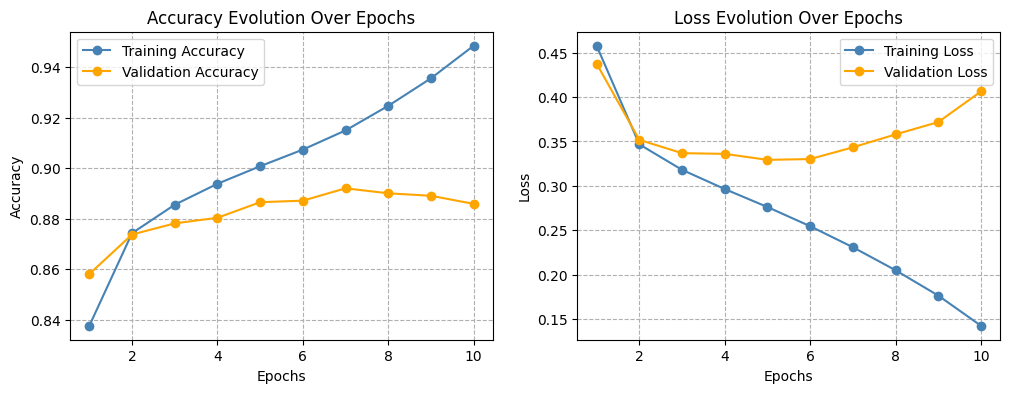

In [106]:
# plot(model.train_max_accuracies, model.valid_max_accuracies, model.avg_train_losses, model.avg_valid_losses, model.train_max_indecies, model.valid_max_indecies)
plot_metrics(or3_train['accuracy'], or3_valid['accuracy'], or3_train['loss'], or3_valid['loss'])

The most frequent label in the dataset is: m


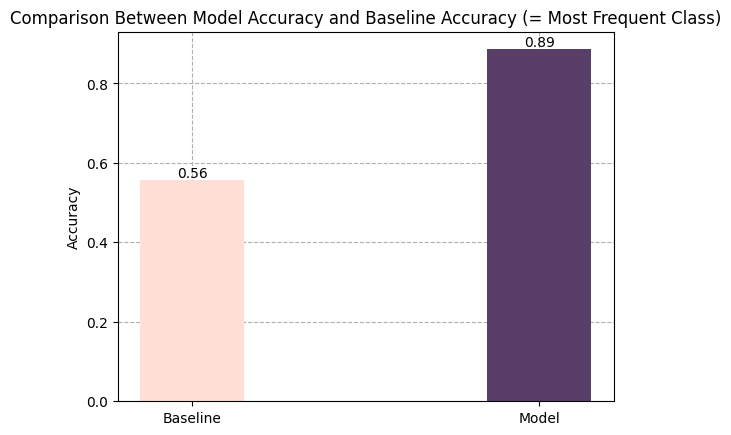

In [107]:
baseline_acc = baseline_accuracy(or3_data_generator, verbose=True)

compare_accuracies(baseline_acc, or3_valid['accuracy'][-1])

word: affiliée
eéiliffa found in the training set.
predictions: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


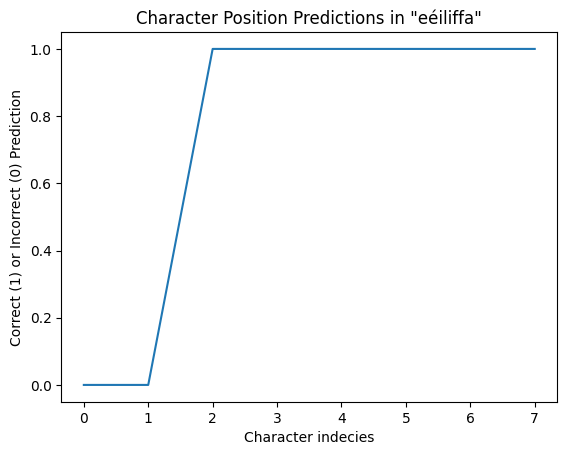

In [119]:
word_0 = orthography_data_3gen['orthography'][0]   # 'à-côté' ✔︎        (plateau at index 0)
word_1 = orthography_data_3gen['orthography'][50]  # 'ablution' ✔︎      (plateau at index 4)
word_2 = orthography_data_3gen['orthography'][100] # 'abside' ✘       
word_3 = orthography_data_3gen['orthography'][150] # 'accessoire' ✔︎    (plateau at index 2)
word_4 = orthography_data_3gen['orthography'][200] # 'accu' ✔︎          (plateau at index 0)
word_5 = orthography_data_3gen['orthography'][250] # 'acquiescement' ✔︎ (plateau at index 0)
word_6 = orthography_data_3gen['orthography'][300] # 'addendum' ✔︎      (plateau at index 0)
word_7 = orthography_data_3gen['orthography'][350] # 'admonition' ✔︎    (plateau at index 5)
word_8 = orthography_data_3gen['orthography'][400] # 'aéroglisseur' ✔︎  (plateau at index 0)
word_9 = orthography_data_3gen['orthography'][450] # 'affiliée' ✔︎      (plateau at index 2)
print(f'word: {word_9}')
reversed_word = reverse_sequence(word_9)
view_plateau(reversed_word, '../saved_models/orthography_3gen.pth')

In [145]:
hyperparameters = {'embed_dim': 128,
                   'hidden_size': 256,
                   'batch_size': 64,
                   'n_epochs': 20,
                   'lr': 0.001}

# Averaging results over 10 runs
or3_t, or3_v = statistical_check(orthography_data_3gen, hyperparameters, runs=10, reverse_nouns=True, df=True, device=DEVICE)

Avg Train Loss: 0.1459   Avg Train Accuracy: 94.76%   Avg Plateau Beginning (index): 6   Avg Plateau Beginning Accuracy: 86.56%
Avg Valid Loss: 0.4325   Avg Valid Accuracy: 88.06%   Avg Plateau Beginning (index): 6   Avg Plateau Beginning Accuracy: 80.00%


### Phonetic Form (3 classes)

In [146]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
n_epochs = 20
batch_size = 64
lr = 0.001

ph3_data_generator = DataGenerator(phonetic_data_3gen, reverse_nouns=True)
ph3_model = GenderLSTM(ph3_data_generator, embedding_dim, hidden_size, device=DEVICE)
ph3_train, ph3_valid = ph3_model.train_model(ph3_data_generator, n_epochs, batch_size, lr)

Epoch: 0
[Train] Loss: 0.5539   Accuracy: 76.86%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 51.56%
[Valid] Loss: 0.5720   Accuracy: 74.95%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 51.56%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.4651   Accuracy: 80.52%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 50.00%
[Valid] Loss: 0.4948   Accuracy: 78.44%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 57.81%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.4325   Accuracy: 82.31%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 60.94%
[Valid] Loss: 0.4767   Accuracy: 80.34%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 64.06%
---------------------------------------------

In [147]:
ph3_predictions = ph3_model.predict(ph3_data_generator, batch_size)
ph3_predictions_df = pd.DataFrame(ph3_predictions)
ph3_predictions_df

,Word,Predicted Gender,True Gender
0,u,m,m
1,u,f,m
2,o,f,m
3,o,m,m
4,yl,m,m
...,...,...,...
6196,tsilajsOslanOjsan,b,b
6197,ʁœtatiʒiditsEʁpim,m,m
6198,̃ɔjsazilajʁEtamEd,f,f
6199,̃ɔjsazilaɥtkElEt̃ɛ,f,f


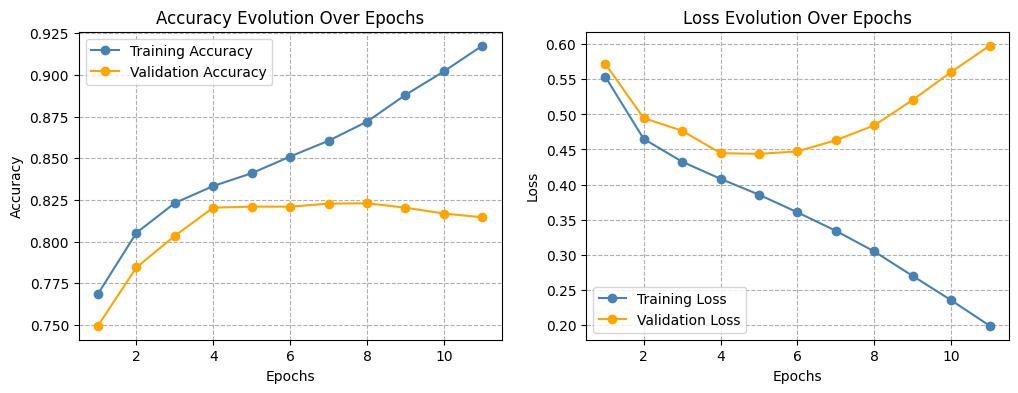

In [187]:
plot_metrics(ph3_train['accuracy'], ph3_valid['accuracy'], ph3_train['loss'], ph3_valid['loss'])

The most frequent label in the dataset is: m


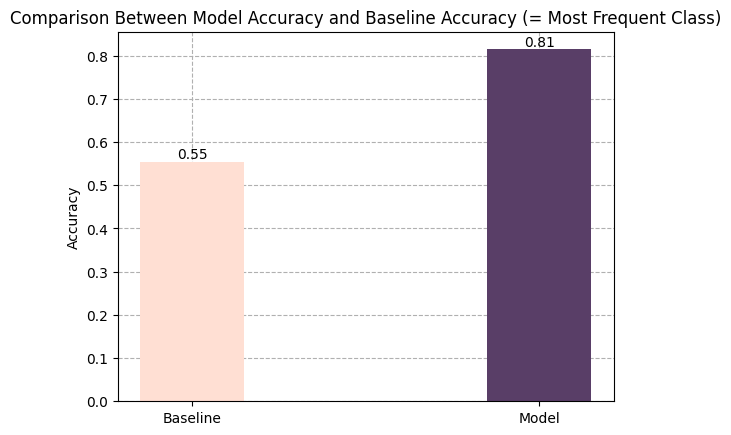

In [149]:
baseline_acc = baseline_accuracy(ph3_data_generator, verbose=True)

compare_accuracies(baseline_acc, ph3_valid['accuracy'][-1])

In [150]:
# Averaging results over 10 runs
ph3_t, ph3_v = statistical_check(phonetic_data_3gen, hyperparameters, runs=10, device=DEVICE)

Avg Train Loss: 0.2870   Avg Train Accuracy: 88.09%   Avg Plateau Beginning (index): 5   Avg Plateau Beginning Accuracy: 67.03%
Avg Valid Loss: 0.5173   Avg Valid Accuracy: 81.26%   Avg Plateau Beginning (index): 4   Avg Plateau Beginning Accuracy: 67.97%


### Orthographic Form (binary)

In [151]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
n_epochs = 20
batch_size = 64
lr = 0.001

orBin_data_generator = DataGenerator(orthography_data_2gen, reverse_nouns=True)
orBin_model = GenderLSTM(orBin_data_generator, embedding_dim, hidden_size, device=DEVICE)
orBin_train, orBin_valid = orBin_model.train_model(orBin_data_generator, n_epochs, batch_size, lr)

Epoch: 0
[Train] Loss: 0.3351   Accuracy: 86.74%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 75.00%
[Valid] Loss: 0.3445   Accuracy: 86.10%   Beginning of plateau (index): 6   Accuracy at the beginning of plateau: 67.19%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2459   Accuracy: 90.18%   Beginning of plateau (index): 3   Accuracy at the beginning of plateau: 85.94%
[Valid] Loss: 0.2548   Accuracy: 89.55%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 78.12%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2235   Accuracy: 90.90%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 76.56%
[Valid] Loss: 0.2473   Accuracy: 89.96%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 78.12%
---------------------------------------------

In [152]:
orBin_predictions = orBin_model.predict(orBin_data_generator, batch_size)
orBin_predictions_df = pd.DataFrame(orBin_predictions)
orBin_predictions_df

,Word,Predicted Gender,True Gender
0,v,m,m
1,fi,m,m
2,ap,f,m
3,og,m,m
4,su,m,m
...,...,...,...
5878,reissitâp-regnaluob,m,m
5879,ellif-etitep-erèirra,f,f
5880,emsinnoisserpmi-tsop,m,m
5881,tnafne-titep-erèirra,m,m


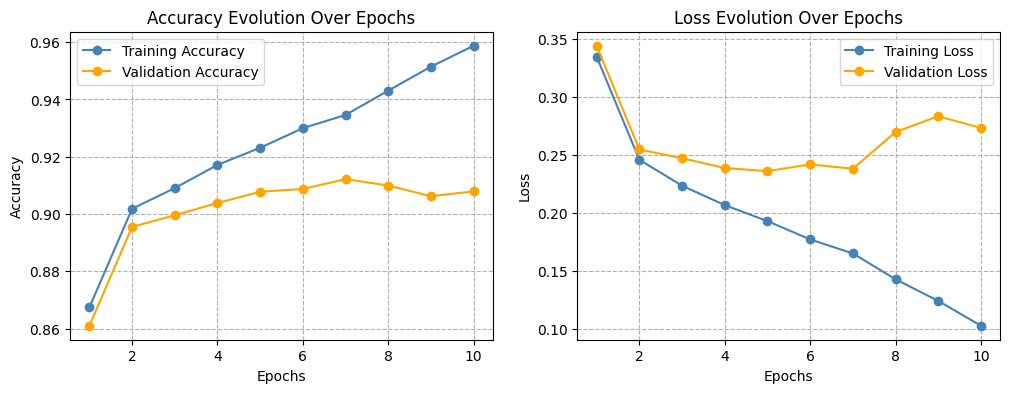

In [188]:
plot_metrics(orBin_train['accuracy'], orBin_valid['accuracy'], orBin_train['loss'], orBin_valid['loss'])

The most frequent label in the dataset is: m


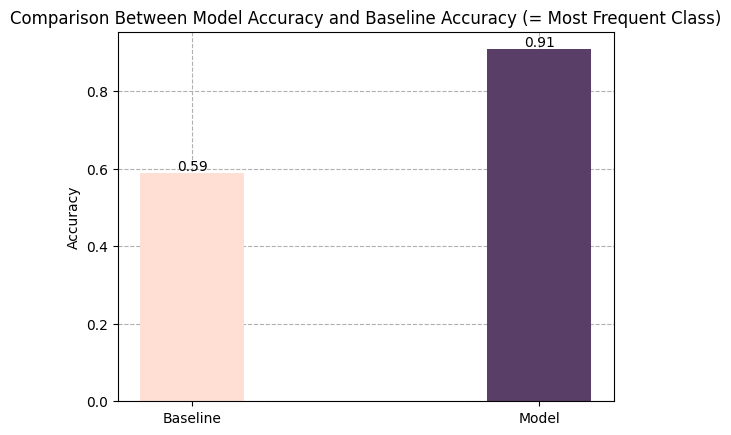

In [154]:
baseline_acc = baseline_accuracy(orBin_data_generator, verbose=True)

compare_accuracies(baseline_acc, orBin_valid['accuracy'][-1])

In [155]:
# Averaging results over 10 runs
or2_t, or2_v = statistical_check(orthography_data_2gen, hyperparameters, runs=10, device=DEVICE)

Avg Train Loss: 0.0631   Avg Train Accuracy: 97.69%   Avg Plateau Beginning (index): 6   Avg Plateau Beginning Accuracy: 93.59%
Avg Valid Loss: 0.3637   Avg Valid Accuracy: 91.07%   Avg Plateau Beginning (index): 6   Avg Plateau Beginning Accuracy: 82.81%


### Phonetic Form (binary)

In [156]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
n_epochs = 20
batch_size = 64
lr = 0.001

phBin_data_generator = DataGenerator(phonetic_data_2gen, reverse_nouns=True)
phBin_model = GenderLSTM(phBin_data_generator, embedding_dim, hidden_size, device=DEVICE)
phBin_train, phBin_valid = phBin_model.train_model(phBin_data_generator, n_epochs, batch_size, lr)

Epoch: 0
[Train] Loss: 0.4221   Accuracy: 79.71%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 50.00%
[Valid] Loss: 0.4149   Accuracy: 80.48%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 68.75%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3575   Accuracy: 83.24%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 68.75%
[Valid] Loss: 0.3615   Accuracy: 82.79%   Beginning of plateau (index): 4   Accuracy at the beginning of plateau: 56.25%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3315   Accuracy: 84.65%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 59.38%
[Valid] Loss: 0.3554   Accuracy: 83.01%   Beginning of plateau (index): 6   Accuracy at the beginning of plateau: 70.31%
---------------------------------------------

In [157]:
phBin_predictions = phBin_model.predict(phBin_data_generator, batch_size)
phBin_predictions_df = pd.DataFrame(phBin_predictions)
phBin_predictions_df

,Word,Predicted Gender,True Gender
0,s,m,m
1,a,m,m
2,yʁ,f,m
3,up,m,m
4,aʒ,m,m
...,...,...,...
5878,nibOlgOmEiskObʁak,f,f
5879,̃ɔjsazilakidEmʁys,f,f
5880,̃ɔjsakinymOkʁɛt̃ɛ,f,f
5881,maʁgOlafEs̃ɑOʁtkElE,m,m


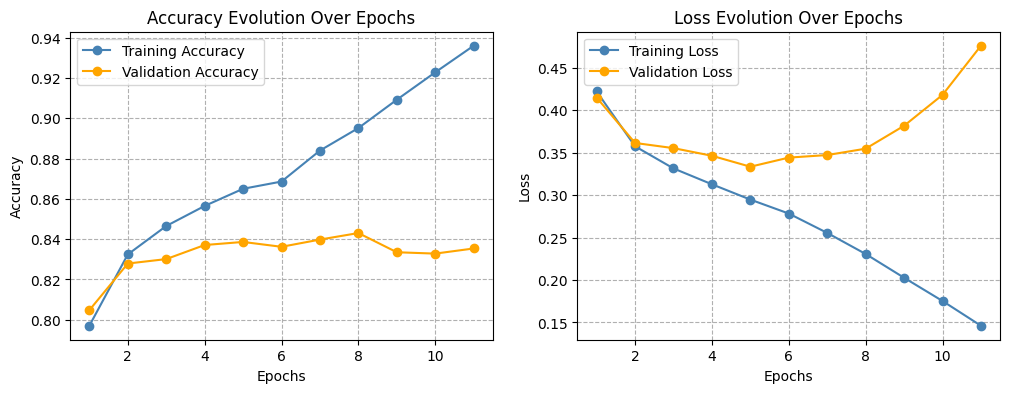

In [189]:
plot_metrics(phBin_train['accuracy'], phBin_valid['accuracy'], phBin_train['loss'], phBin_valid['loss'])

The most frequent label in the dataset is: m


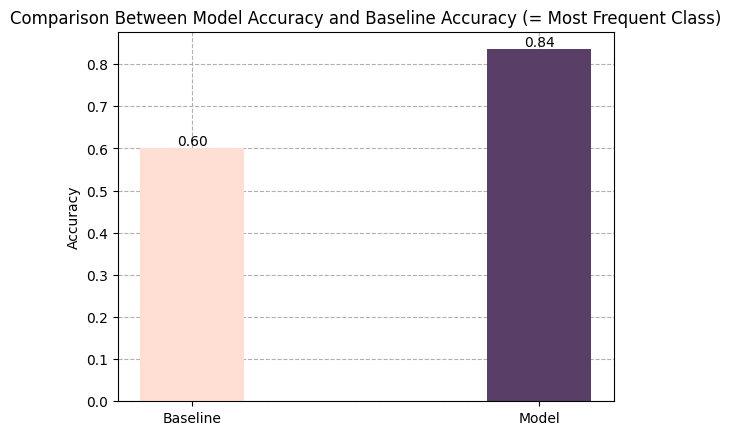

In [159]:
baseline_acc = baseline_accuracy(phBin_data_generator, verbose=True)

compare_accuracies(baseline_acc, phBin_valid['accuracy'][-1])

In [160]:
# Averaging results over 10 runs
ph2_t, ph2_v = statistical_check(phonetic_data_2gen, hyperparameters, runs=10, device=DEVICE)

Avg Train Loss: 0.1908   Avg Train Accuracy: 91.45%   Avg Plateau Beginning (index): 5   Avg Plateau Beginning Accuracy: 74.53%
Avg Valid Loss: 0.4340   Avg Valid Accuracy: 83.16%   Avg Plateau Beginning (index): 4   Avg Plateau Beginning Accuracy: 70.16%


In [169]:
data = {'Orthographic Form (M/F/B)': [f"{(or3_t['avg_accuracy'].item() * 100):.2f}%", f"{(or3_v['avg_accuracy'].item() * 100):.2f}%"],
        'Phonetic Form (M/F/B)': [f"{(ph3_t['avg_accuracy'].item() * 100):.2f}%", f"{(ph3_v['avg_accuracy'].item() * 100):.2f}%"],
        'Orthographic Form (M/F)': [f"{(or2_t['avg_accuracy'].item() * 100):.2f}%", f"{(or2_v['avg_accuracy'].item() * 100):.2f}%"], 
        'Phonetic Form (M/F)': [f"{(ph2_t['avg_accuracy'].item() * 100):.2f}%", f"{(ph2_v['avg_accuracy'].item() * 100):.2f}%"]}

accuracy_results = pd.DataFrame(data).rename(index={0:'Training Accuracy', 1: 'Validation Accuracy'})
accuracy_results

,Orthographic Form (M/F/B),Phonetic Form (M/F/B),Orthographic Form (M/F),Phonetic Form (M/F)
Training Accuracy,94.76%,88.09%,97.69%,91.45%
Validation Accuracy,88.06%,81.26%,91.07%,83.16%


In [170]:
or3_t

{'avg_accuracy': tensor(0.9476),
 'avg_loss': 0.14588457543511527,
 'avg_plateau_beg': 6,
 'avg_acc_at_plateau_beg': tensor(0.8656)}

In [173]:
plateau_data = {'Orthographic Form': [or3_t['avg_plateau_beg'], or3_v['avg_plateau_beg']],
                'Phonetic Form': [ph3_t['avg_plateau_beg'], ph3_v['avg_plateau_beg']],
                }

plateau_results = pd.DataFrame(plateau_data).rename(index={0:'Training Set', 1: 'Validation Set'})
plateau_results

,Orthographic Form,Phonetic Form
Training Set,6,5
Validation Set,6,4
